# Topic Model For Abstracts

## Prepare data for LDA Analysis

In [15]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from pprint import pprint
#nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

In [4]:
papers = pd.read_csv('./Dataset_00_02_10_cleaned.csv')
papers.head(5)

,Title,Year,Cited by,Affiliations,Abstract,Author Keywords,Index Keywords,paper_Title_processed,paper_Abstract_processed
0,Connectionism and cognitive architecture: A cr...,1988,1606.0,"CUNY Graduate Center, United States; Universit...",This paper explores differences between Connec...,NaN,article; brain; cognition; human; linguistics;...,connectionism and cognitive architecture a cri...,this paper explores differences between connec...
1,Implicit Learning and Tacit Knowledge,1989,1213.0,"Brooklyn College, the Graduate Center, City Un...","I examine the phenomenon of implicit learning,...",NaN,NaN,implicit learning and tacit knowledge,i examine the phenomenon of implicit learning ...
2,Stable Adaptive Teleoperation,1991,1091.0,"Nonlinear Systems Laboratory, Massachusetts In...","Telerobotics, the body of science and technolo...",NaN,"Control Systems, Cascade; Control Systems, Del...",stable adaptive teleoperation,telerobotics the body of science and technolog...
3,Hippocampal synaptic enhancement and informati...,1987,885.0,"Department of Psychology, University of Colora...",The hypothesis that the physical substrate of ...,NaN,animal experiment; central nervous system; ele...,hippocampal synaptic enhancement and informati...,the hypothesis that the physical substrate of ...
4,Catastrophic Interference in Connectionist Net...,1989,803.0,NaN,Connectionist networks in which information is...,NaN,NaN,catastrophic interference in connectionist net...,connectionist networks in which information is...


In [5]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36303 entries, 0 to 36302
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Title                     36303 non-null  object 
 1   Year                      36303 non-null  int64  
 2   Cited by                  27081 non-null  float64
 3   Affiliations              34527 non-null  object 
 4   Abstract                  36303 non-null  object 
 5   Author Keywords           22539 non-null  object 
 6   Index Keywords            16881 non-null  object 
 7   paper_Title_processed     36303 non-null  object 
 8   paper_Abstract_processed  36303 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.5+ MB


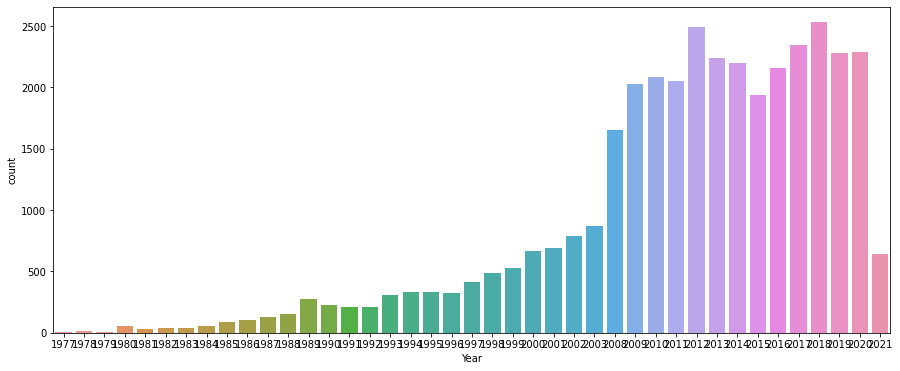

In [6]:
plt.figure(figsize=(15,6))
sns.countplot(x='Year', data=papers);

In [7]:
data = papers.paper_Abstract_processed.values.tolist()

In [21]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(data, min_count=20, threshold=100) 
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [22]:
stop_words = stopwords.words('english')
extension = ['from','subject','edu','re','use', 'high','study','analysis','include','paper','article','make','author','show','present','method','result','reserch','work','effect','model','design','role','main','approach','purpose','implication','finding','methodology','understanding','address','limited','process','case','scenario','provide','application','collect','analyze','amount','share','question','regard','compare','perform','obtain','feature','impact','adoption','implementation','early','improve']
stop_words.extend(extension)

In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []

    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [25]:
data_ready = process_words(data)  

In [26]:
data_ready[0]

['explore',
 'difference',
 'connectionist',
 'proposal',
 'cognitive',
 'architecture',
 'sort',
 'traditionally',
 'assume',
 'cognitive',
 'science',
 'claim',
 'major',
 'distinction',
 'connectionist',
 'classical',
 'architecture',
 'postulate',
 'mental',
 'state',
 'latter',
 'former',
 'committed',
 'symbol',
 'level',
 'representation',
 'language',
 'think',
 'state',
 'combinatorial',
 'syntactic',
 'semantic',
 'structure',
 'several',
 'argument',
 'combinatorial',
 'structure',
 'mental',
 'representation',
 'review',
 'argument',
 'base',
 'systematicity',
 'mental',
 'representation',
 'fact',
 'cognitive',
 'capacity',
 'always',
 'exhibit',
 'certain',
 'symmetry',
 'ability',
 'entertain',
 'give',
 'thought',
 'imply',
 'ability',
 'entertain',
 'thought',
 'semantically',
 'relate',
 'content',
 'claim',
 'argument',
 'powerful',
 'mind',
 'brain',
 'architecture',
 'connectionist',
 'cognitive',
 'level',
 'consider',
 'possibility',
 'connectionism',
 'account',

In [29]:
# display a progress meter
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=50, step=1, cpus=1, random_seed=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary,random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores

## TF Model

In [27]:
# Create Dictionary
id2word_Abstract = corpora.Dictionary(data_ready)
# Create Corpus
texts = data_ready
# Term Document Frequency
bow_corpus_Abstract = [id2word_Abstract.doc2bow(text) for text in texts]
# View
print(bow_corpus_Abstract[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 4), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 5), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1)]]


### فراوانی کلمات 

In [28]:
dict_corpus = {}

for i in range(len(bow_corpus_Abstract)):
  for idx, freq in bow_corpus_Abstract[i]:
    if id2word_Abstract[idx] in dict_corpus:
      dict_corpus[id2word_Abstract[idx]] += freq
    else:
       dict_corpus[id2word_Abstract[idx]] = freq

In [29]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])
dict_df.sort_values('freq', ascending=False).head(50)

,freq
cognitive,62400
science,48963
research,20562
human,19935
theory,19389
system,18474
base,14460
information,11787
learn,11502
cognition,11445


### یافتن بهترین مدل

In [33]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus_Abstract, texts=data_ready, dictionary=id2word_Abstract,
                                                               start_topic_count=2, end_topic_count=50, step=1, cpus=4)

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [6:57:15<00:00, 510.93s/it]


In [42]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 51, 1), 'Coherence Score': np.round(coherence_scores, 4)})

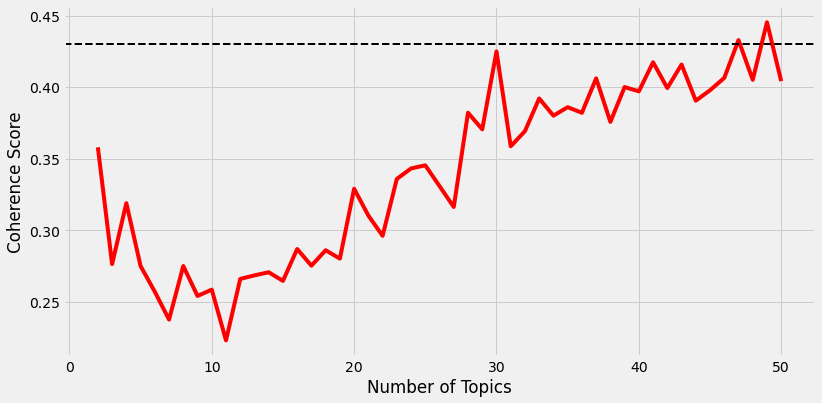

In [43]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


x_ax = range(2, 51, 1)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.43, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

In [44]:
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(60)

,Number of Topics,Coherence Score
47,49,0.4453
45,47,0.4329
28,30,0.4249
39,41,0.4174
41,43,0.4158
44,46,0.4065
35,37,0.4061
46,48,0.4051
48,50,0.4042
37,39,0.4000


## TF-IDF Model

In [30]:
tfidf_Abstract = gensim.models.TfidfModel(bow_corpus_Abstract)
corpus_tfidf_Abstract = tfidf_Abstract[bow_corpus_Abstract]

#for doc in corpus_tfidf_Abstract:
#    pprint(doc)
#    break

### یافتن بهترین مدل 

In [38]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus_tfidf_Abstract, texts=data_ready, dictionary=id2word_Abstract,
                                                               start_topic_count=2, end_topic_count=50, step=1, cpus=4)

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [7:33:22<00:00, 555.15s/it]


In [39]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 51, 1), 'Coherence Score': np.round(coherence_scores, 4)})

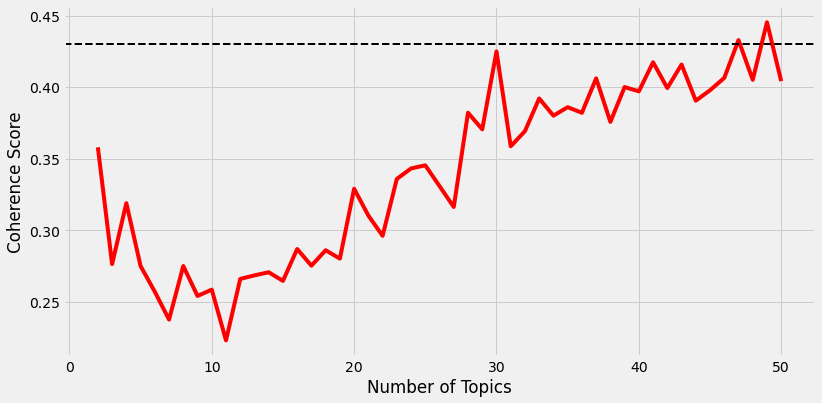

In [40]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


x_ax = range(2, 51, 1)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.43, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

In [41]:
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(60)

,Number of Topics,Coherence Score
47,49,0.4453
45,47,0.4329
28,30,0.4249
39,41,0.4174
41,43,0.4158
44,46,0.4065
35,37,0.4061
46,48,0.4051
48,50,0.4042
37,39,0.4000


## Running LDA using Bag of Words

In [31]:
num_topics = 30
# Build LDA model
lda_model_Abstract_bow =  gensim.models.ldamodel.LdaModel(corpus=bow_corpus_Abstract,
                                       id2word=id2word_Abstract,
                                       num_topics=num_topics,random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model_Abstract_bow.print_topics())
doc_lda_Abstract_bow = lda_model_Abstract_bow[bow_corpus_Abstract]

[(11,
  '0.397*"cultural" + 0.214*"culture" + 0.127*"affective" + '
  '0.089*"anthropology" + 0.039*"transmission" + 0.037*"slow" + '
  '0.000*"animating" + 0.000*"upitt" + 0.000*"spacetime" + '
  '0.000*"interconceptual"'),
 (6,
  '0.122*"reasoning" + 0.121*"patient" + 0.081*"inference" + 0.076*"express" + '
  '0.069*"treatment" + 0.060*"positive" + 0.058*"schema" + 0.052*"heuristic" + '
  '0.046*"rationality" + 0.041*"disease"'),
 (25,
  '0.338*"self" + 0.270*"mental" + 0.151*"consciousness" + 0.048*"section" + '
  '0.044*"awareness" + 0.030*"defend" + 0.018*"theorize" + 0.017*"folk" + '
  '0.017*"state" + 0.012*"phenomenal"'),
 (26,
  '0.110*"bias" + 0.094*"move" + 0.086*"distribute" + 0.076*"old" + '
  '0.055*"item" + 0.044*"train" + 0.037*"small" + 0.036*"unit" + 0.033*"stand" '
  '+ 0.032*"dimensional"'),
 (5,
  '0.187*"argument" + 0.177*"abstract" + 0.089*"thought" + 0.085*"classical" + '
  '0.054*"thesis" + 0.047*"symbol" + 0.038*"imply" + 0.034*"traditionally" + '
  '0.026*"un

## Running LDA using TF-IDF

In [64]:
num_topics = 30
# Build LDA model
lda_model_Abstract_tfidf =  gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf_Abstract,
                                       id2word=id2word_Abstract,
                                       num_topics=num_topics,random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model_Abstract_tfidf.print_topics())
doc_lda_Abstract_tfidf = lda_model_Abstract_tfidf[corpus_tfidf_Abstract]

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(15,
  '0.000*"pittsburg" + 0.000*"interconceptual" + 0.000*"unfit" + 0.000*"mrkp" '
  '+ 0.000*"autocorrelated" + 0.000*"spacetime" + 0.000*"colombo" + '
  '0.000*"upitt" + 0.000*"hierarchic" + 0.000*"ontolook"'),
 (21,
  '0.005*"tree" + 0.000*"upitt" + 0.000*"mrkp" + 0.000*"autocorrelated" + '
  '0.000*"spacetime" + 0.000*"pittsburg" + 0.000*"animating" + '
  '0.000*"interconceptual" + 0.000*"motifs" + 0.000*"swoogle"'),
 (8,
  '0.107*"agency" + 0.011*"chess" + 0.000*"interconceptual" + '
  '0.000*"autocorrelated" + 0.000*"spacetime" + 0.000*"pittsburg" + '
  '0.000*"upitt" + 0.000*"unfit" + 0.000*"animating" + 0.000*"hierarchic"'),
 (17,
  '0.029*"sensitivity" + 0.023*"selective" + 0.021*"deficit" + '
  '0.010*"dissociation" + 0.010*"serial" + 0.000*"interconceptual" + '
  '0.000*"ontolook" + 0.000*"ensconce" + 0.000*"upitt" + 0.000*"calligraphy"'),
 (23,
  '0.054*"name" + 0.036*"programming" + 0.021*"rank" + 0.016*"utterance" + '
  '0.000*"autocorrelated" + 0.000*"spacetime" + 0.0

## Analyzing LDA model results

### 1. Bag of Words Model

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\D.M\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [34]:
lda_viz_Abstract_bow = gensimvis.prepare(lda_model_Abstract_bow, bow_corpus_Abstract, id2word_Abstract)
pyLDAvis.save_html(lda_viz_Abstract_bow, './web/bow_Abstract_'+ str(num_topics) +'.html')
lda_viz_Abstract_bow

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.317377  0.113435       1        1  29.153780
17    -0.203276  0.357405       2        1  14.600564
22    -0.217512 -0.120849       3        1   8.545288
18    -0.181361 -0.105124       4        1   6.578446
2     -0.191085 -0.161911       5        1   5.485376
19    -0.050107 -0.114219       6        1   5.010274
9     -0.035239  0.019778       7        1   2.833783
8     -0.005328 -0.057453       8        1   2.450614
15     0.013767 -0.071831       9        1   2.048453
0     -0.036106 -0.131076      10        1   1.915023
4      0.027831 -0.020281      11        1   1.653619
3      0.027939 -0.009384      12        1   1.634117
20     0.032831  0.012513      13        1   1.532183
24     0.043074 -0.000218      14        1   1.329047
28     0.047632 -0.021232      15        1   1.289545
14     0.038315 -0.049192      16        1   1.246100
12     0.027879  0.037424      17        1   1.243800
27     0.059608  0.002695      18        1   1.123491
16     0.060017  0.012826      19        1   1.109134
7      0.065200  0.015460      20        1   1.049892
10     0.063508  0.014402      21        1   1.041762
29     0.066409  0.005765      22        1   0.962498
21     0.079380  0.023571      23        1   0.875691
23     0.083483  0.025621      24        1   0.844774
25     0.058178  0.038738      25        1   0.841591
13     0.074404  0.056797      26        1   0.822426
26     0.086878  0.026242      27        1   0.821495
6      0.074151  0.030041      28        1   0.808759
5      0.089557  0.031977      29        1   0.775369
11     0.117350  0.038078      30        1   0.373107, topic_info=              Term          Freq         Total Category  logprob  loglift
13       cognitive  81177.000000  81177.000000  Default  30.0000  30.0000
51         science  60981.000000  60981.000000  Default  29.0000  29.0000
153          human  27973.000000  27973.000000  Default  28.0000  28.0000
111       research  28415.000000  28415.000000  Default  27.0000  27.0000
187         system  20889.000000  20889.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
19   connectionist      0.035006    372.597919  Topic30 -12.7065  -3.6817
20        consider      0.035006   7346.129004  Topic30 -12.7065  -6.6631
21         content      0.035006   4058.117233  Topic30 -12.7065  -6.0696
22      difference      0.035006   3719.023329  Topic30 -12.7065  -5.9824
23     distinction      0.035006   2567.932881  Topic30 -12.7065  -5.6120

[1081 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.863121   ability
0         5  0.136569   ability
1        29  0.999776  abstract
281       4  0.999495  academic
990       7  0.998891    access
...     ...       ...       ...
814       1  0.007943     world
814       2  0.992003     world
2170     25  0.990605    writer
815       4  0.999621      year
1519     20  0.998274     young

[1037 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 18, 23, 19, 3, 20, 10, 9, 16, 1, 5, 4, 21, 25, 29, 15, 13, 28, 17, 8, 11, 30, 22, 24, 26, 14, 27, 7, 6, 12])

In [47]:
tm = lda_model_Abstract_bow[bow_corpus_Abstract[1]]
tm

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([(0, 0.06172622),
  (1, 0.32944554),
  (2, 0.076596394),
  (3, 0.05401082),
  (5, 0.021286938),
  (7, 0.012909584),
  (12, 0.022037974),
  (13, 0.012176431),
  (14, 0.013414658),
  (15, 0.01659305),
  (16, 0.013091316),
  (17, 0.104541026),
  (18, 0.050909914),
  (19, 0.04371688),
  (22, 0.10282636)],
 [(1, [5]),
  (7, [2, 1, 22, 0]),
  (13, [17, 1]),
  (48, [1, 22, 18]),
  (50, [18]),
  (51, [17]),
  (58, [1]),
  (67, [19]),
  (68, [3, 1, 0]),
  (69, [1]),
  (70, [17]),
  (71, [1]),
  (72, [17]),
  (73, [19]),
  (74, [1, 22]),
  (75, [1]),
  (76, [14]),
  (77, [1, 18, 17]),
  (78, [22]),
  (79, [1]),
  (80, [18]),
  (81, [2]),
  (82, [7]),
  (83, [19]),
  (84, [17, 22, 1]),
  (85, [22]),
  (86, [1, 22]),
  (87, [1]),
  (88, [1]),
  (89, [12]),
  (90, [1]),
  (91, [1]),
  (92, [1]),
  (93, [22]),
  (94, [15]),
  (95, [17]),
  (96, [3]),
  (97, [0]),
  (98, [0]),
  (99, [16]),
  (100, []),
  (101, [22]),
  (102, [1]),
  (103, [1]),
  (104, [1, 17]),
  (105, [13]),
  (106, [2]),
  (107,

In [72]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model_Abstract_bow.show_topic(n, topn=20)] for n in range(0, lda_model_Abstract_bow.num_topics)]
topics

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('learn', 0.217),
  ('learning', 0.136),
  ('student', 0.106),
  ('education', 0.082),
  ('educational', 0.05),
  ('skill', 0.048),
  ('training', 0.04),
  ('course', 0.033),
  ('teaching', 0.03),
  ('school', 0.029),
  ('teach', 0.028),
  ('assessment', 0.026),
  ('mathematic', 0.026),
  ('practice', 0.017),
  ('instruction', 0.014),
  ('module', 0.013),
  ('pedagogical', 0.011),
  ('editor', 0.008),
  ('educator', 0.008),
  ('instructional', 0.008)],
 [('theory', 0.026),
  ('concept', 0.016),
  ('also', 0.014),
  ('experience', 0.014),
  ('well', 0.014),
  ('different', 0.012),
  ('propose', 0.011),
  ('base', 0.01),
  ('level', 0.009),
  ('action', 0.009),
  ('account', 0.009),
  ('need', 0.009),
  ('conceptual', 0.009),
  ('form', 0.009),
  ('framework', 0.009),
  ('context', 0.008),
  ('discuss', 0.008),
  ('first', 0.008),
  ('develop', 0.008),
  ('structure', 0.008)],
 [('human', 0.165),
  ('system', 0.123),
  ('problem', 0.071),
  ('base', 0.048),
  ('interaction', 0.043),
  

In [73]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model_Abstract_bow.num_topics+1)]).T
topics_df.head()

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,learn,theory,human,knowledge,perception,argument,reasoning,content,information,mind,...,language,performance,datum,value,emotion,self,bias,scientific,recognition,measure
Term2,learning,concept,system,representation,visual,abstract,patient,child,social,argue,...,linguistic,project,task,available,agent,mental,move,book,category,health
Term3,student,also,problem,domain,object,thought,inference,face,springer,body,...,text,conduct,time,program,movement,consciousness,distribute,philosophical,engineering,error
Term4,education,experience,base,power,explanation,classical,express,position,user,view,...,medical,transfer,attention,background,chapter,section,old,foundation,agency,speech
Term5,educational,well,interaction,expert,perceptual,thesis,treatment,thing,individual,notion,...,read,big,experiment,assess,emotional,awareness,item,creativity,management,service


In [74]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model_Abstract_bow.num_topics+1)] )
topics_df


C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-74-981d32552536>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"learn, learning, student, education, educational, skill, training, course, teaching, school, teach, assessment, mathematic, practice, instruction, module, pedagogical, editor, educator, instructional"
Topic2,"theory, concept, also, experience, well, different, propose, base, level, action, account, need, conceptual, form, framework, context, discuss, first, develop, structure"
Topic3,"human, system, problem, base, interaction, technology, environment, computer, machine, solve, robot, architecture, propose, enhance, ieee, implement, complex, develop, law, intelligent"
Topic4,"knowledge, representation, domain, power, expert, acquire, automatic, efficient, operate, acquisition, scheme, validate, hybrid, aid, store, automate, architectural, agree, lay, synthetic"
Topic5,"perception, visual, object, explanation, perceptual, motor, target, causal, learner, sensory, vision, conceive, radical, analogy, concrete, stem, prime, perceive, branch, compatible"
Topic6,"argument, abstract, thought, classical, thesis, symbol, imply, traditionally, unconscious, favor, former, theorist, neurological, syntactic, connectionist, neurology, symmetry, british, connectionism, semantically"
Topic7,"reasoning, patient, inference, express, treatment, positive, schema, heuristic, rationality, disease, probabilistic, false, head, diagnostic, programme, default, causation, calculation, doubt, david"
Topic8,"content, child, face, position, thing, namely, status, version, naturalistic, ontological, mix, epistemological, young, elaborate, root, critique, naturalism, failure, dualism, advocate"
Topic9,"information, social, springer, user, individual, communication, product, evaluation, search, public, document, opportunity, innovation, unique, retrieval, force, expertise, intellectual, neuron, verlag"
Topic10,"mind, argue, body, view, notion, physical, claim, debate, traditional, distinction, methodological, explanatory, historical, distinct, tradition, conception, connect, access, rather, controversial"


In [75]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [30, 20]

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


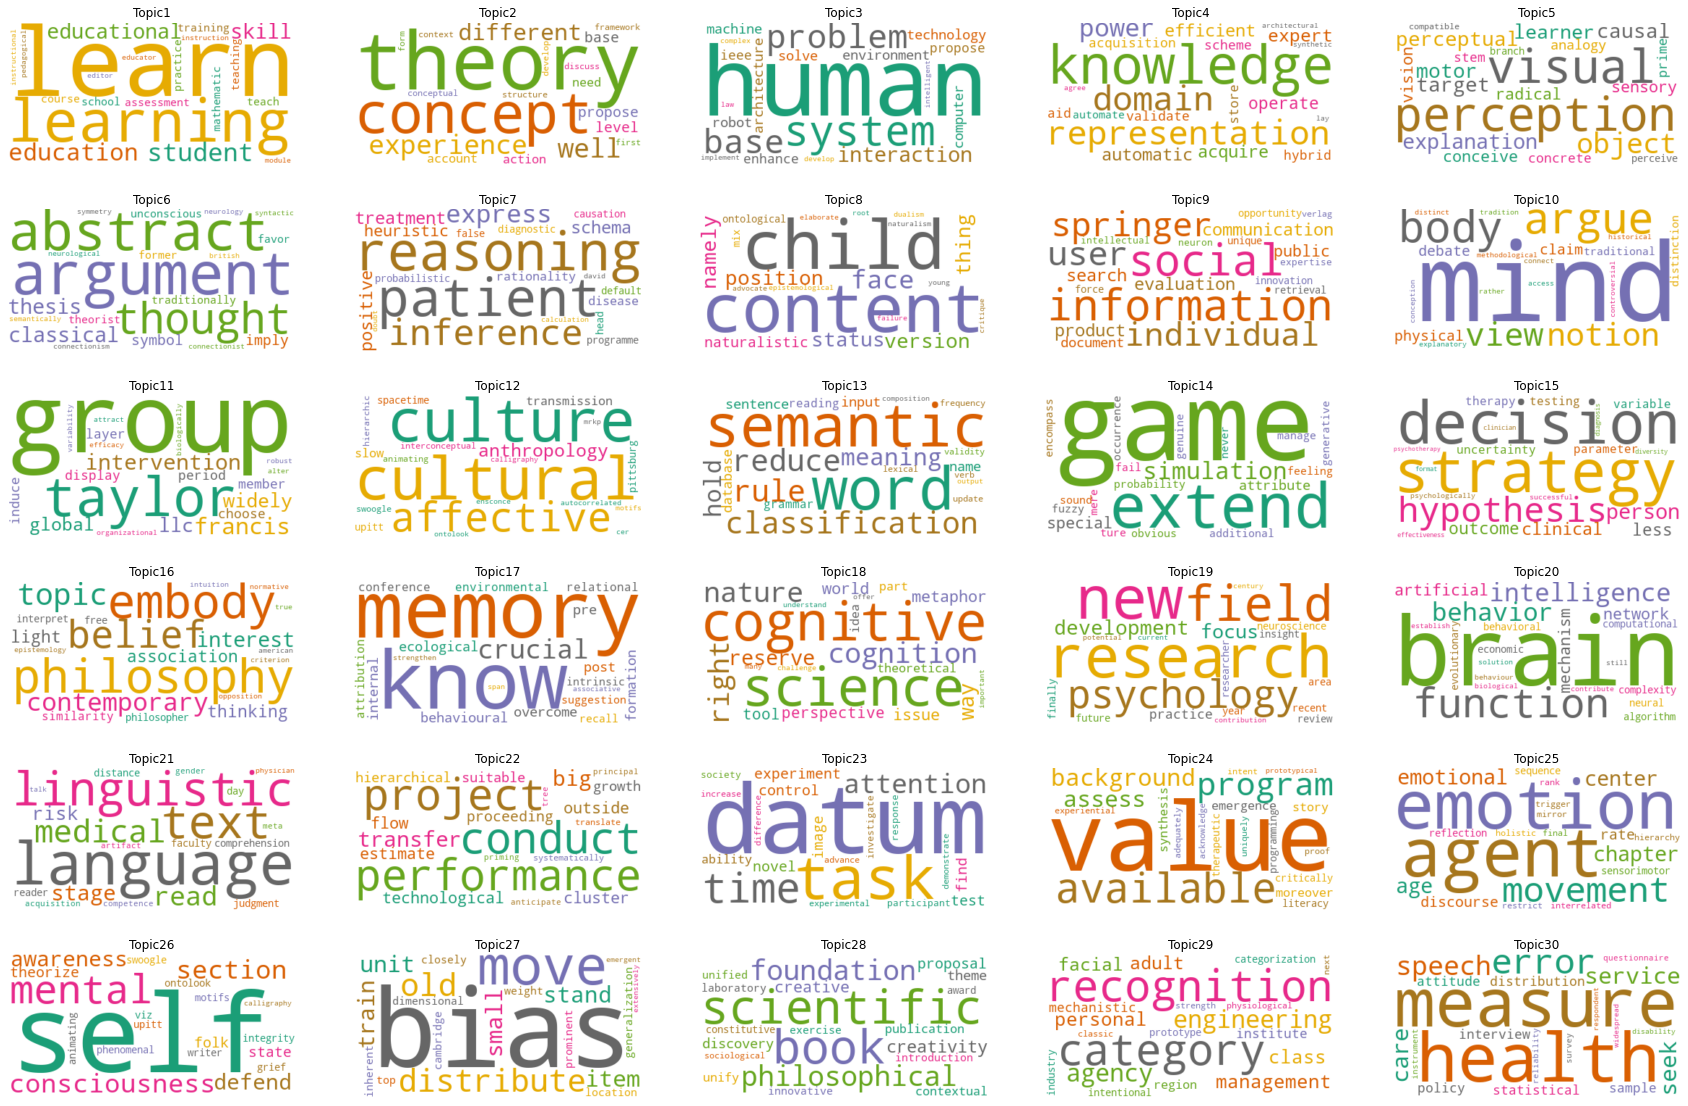

In [76]:
# Create subplots for each topic
for i in range(30):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(6, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

### 2. TF-IDF Model

In [65]:
lda_viz_Abstract_tfidf = gensimvis.prepare(lda_model_Abstract_tfidf, corpus_tfidf_Abstract, id2word_Abstract)
pyLDAvis.save_html(lda_viz_Abstract_tfidf, './web/tfidf_Abstract_'+ str(num_topics) +'.html')
lda_viz_Abstract_tfidf

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.383753 -0.362834  1       1        35.946252
12     0.326988  0.204001  2       1        14.780866
19     0.319789  0.215576  3       1        14.542401
26     0.179183 -0.000399  4       1        6.921116 
18     0.141430 -0.000167  5       1        4.929266 
14     0.112070 -0.000559  6       1        4.261040 
16     0.102427 -0.000642  7       1        3.965303 
11     0.027176 -0.001707  8       1        2.283333 
4      0.013703 -0.001945  9       1        2.043268 
9     -0.016600 -0.002338  10      1        1.612611 
6     -0.030159 -0.002476  11      1        1.233778 
3     -0.048495 -0.002628  12      1        1.078905 
0     -0.047766 -0.002620  13      1        1.052678 
20    -0.071528 -0.002678  14      1        0.681767 
28    -0.074378 -0.002668  15      1        0.596852 
25    -0.075843 -0.002661  16      1        0.575549 
24    -0.080238 -0.002628  17      1        0.464286 
13    -0.082951 -0.002596  18      1        0.435327 
2     -0.083609 -0.002586  19      1        0.431022 
27    -0.084319 -0.002575  20      1        0.383293 
5     -0.086439 -0.002536  21      1        0.368067 
22    -0.084443 -0.002574  22      1        0.351103 
29    -0.087137 -0.002521  23      1        0.321026 
10    -0.087116 -0.002522  24      1        0.263204 
7     -0.091836 -0.002365  25      1        0.225249 
23    -0.094167 -0.002199  26      1        0.124520 
17    -0.094712 -0.002127  27      1        0.063358 
8     -0.094290 -0.002185  28      1        0.038931 
21    -0.095249 -0.001927  29      1        0.021066 
15    -0.095242 -0.001915  30      1        0.004562 , topic_info=            Term         Freq        Total Category  logprob  loglift
124   available   1310.000000  1310.000000  Default  30.0000  30.0000
1089  user        587.000000   587.000000   Default  29.0000  29.0000
1504  philosophy  417.000000   417.000000   Default  28.0000  28.0000
1082  springer    509.000000   509.000000   Default  27.0000  27.0000
1     abstract    1450.000000  1450.000000  Default  26.0000  26.0000
...        ...            ...          ...      ...      ...      ...
25    exhibit     0.000309     69.136920    Topic30 -10.3822 -2.3231 
26    explore     0.000309     310.886533   Topic30 -10.3822 -3.8264 
27    fact        0.000309     165.235475   Topic30 -10.3822 -3.1944 
28    favor       0.000309     56.415353    Topic30 -10.3822 -2.1197 
29    former      0.000309     56.612590    Topic30 -10.3822 -2.1232 

[1292 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0     1      0.999127  ability   
1945  20     0.907447  absence   
1     1      0.999514  abstract  
990   18     0.980480  access    
282   5      0.995497  accord    
...   ..          ...     ...    
280   7      0.997750  widely    
2115  10     0.977204  widespread
1052  5      0.990453  wiley     
1434  13     0.966682  working   
448   14     0.993127  yet       

[575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 13, 20, 27, 19, 15, 17, 12, 5, 10, 7, 4, 1, 21, 29, 26, 25, 14, 3, 28, 6, 23, 30, 11, 8, 24, 18, 9, 22, 16])

In [66]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model_Abstract_tfidf.show_topic(n, topn=20)] for n in range(0, lda_model_Abstract_tfidf.num_topics)]
topics

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('image', 0.07),
  ('map', 0.049),
  ('document', 0.047),
  ('bring', 0.047),
  ('eye', 0.046),
  ('public', 0.037),
  ('briefly', 0.028),
  ('retrieval', 0.025),
  ('expectation', 0.021),
  ('applicable', 0.02),
  ('verbal', 0.02),
  ('record', 0.018),
  ('bear', 0.016),
  ('working', 0.013),
  ('cortex', 0.011),
  ('controversy', 0.01),
  ('protocol', 0.01),
  ('library', 0.009),
  ('ambiguity', 0.009),
  ('label', 0.009)],
 [('abstract', 0.018),
  ('human', 0.012),
  ('research', 0.011),
  ('theory', 0.01),
  ('system', 0.01),
  ('cognition', 0.009),
  ('self', 0.009),
  ('learn', 0.008),
  ('concept', 0.008),
  ('base', 0.008),
  ('knowledge', 0.008),
  ('representation', 0.008),
  ('brain', 0.008),
  ('experience', 0.007),
  ('decision', 0.007),
  ('body', 0.007),
  ('problem', 0.007),
  ('propose', 0.007),
  ('datum', 0.007),
  ('learning', 0.007)],
 [('key', 0.098),
  ('light', 0.059),
  ('orient', 0.039),
  ('database', 0.035),
  ('easy', 0.029),
  ('automation', 0.018),
  ('

In [67]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model_Abstract_tfidf.num_topics+1)]).T
topics_df.head()

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,image,abstract,key,active,position,reality,participant,device,agency,debate,...,medical,tree,contribution,name,advance,chapter,available,target,bias,translation
Term2,map,human,light,integration,end,evolution,game,version,chess,measure,...,matter,slaving,century,programming,choice,center,practice,read,specification,speech
Term3,document,research,orient,community,open,gesture,publishing,critique,unfit,service,...,stage,wherewithal,ecology,rank,especially,old,often,overall,situation,operate
Term4,bring,theory,database,sentence,similarity,leave,special,talk,wherewithal,health,...,yet,inch,interesting,utterance,assess,advantage,visual,stem,accuracy,hybrid
Term5,eye,system,easy,cover,nevertheless,literacy,express,failure,neurofeedback,low,...,risk,calligraphy,hierarchical,neurofeedback,story,item,book,proceeding,pedagogical,automate


In [68]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, lda_model_Abstract_bow.num_topics+1)] )
topics_df


C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-68-981d32552536>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"image, map, document, bring, eye, public, briefly, retrieval, expectation, applicable, verbal, record, bear, working, cortex, controversy, protocol, library, ambiguity, label"
Topic2,"abstract, human, research, theory, system, cognition, self, learn, concept, base, knowledge, representation, brain, experience, decision, body, problem, propose, datum, learning"
Topic3,"key, light, orient, database, easy, automation, mere, structured, foster, flexible, animating, ontolook, swoogle, motifs, ensconce, cer, calligraphy, upitt, hierarchic, notebaert"
Topic4,"active, integration, community, sentence, cover, unify, realize, efficiency, unified, puzzle, transition, specify, balance, candidate, vary, enterprise, explicitly, entire, constructivist, expressive"
Topic5,"position, end, open, similarity, nevertheless, direction, modeling, schema, sensory, learner, animal, structural, radical, conceive, third, meet, degree, analogy, concrete, emphasis"
Topic6,"reality, evolution, gesture, leave, literacy, actual, break, primate, independence, injury, autocorrelated, pittsburg, unfit, upitt, spacetime, ontolook, animating, swoogle, mrkp, interconceptual"
Topic7,"participant, game, publishing, special, express, philosopher, cross, positive, opposition, true, false, note, classic, next, questionnaire, easily, strategic, genuine, causation, programme"
Topic8,"device, version, critique, talk, failure, blending, functionalism, upitt, interconceptual, animating, spacetime, ontolook, swoogle, hierarchic, motifs, cer, calligraphy, unfit, pittsburg, ensconce"
Topic9,"agency, chess, unfit, wherewithal, neurofeedback, mrkp, autocorrelated, spacetime, pittsburg, upitt, interconceptual, animating, ontolook, swoogle, hierarchic, motifs, cer, colombo, somato, barch"
Topic10,"debate, measure, service, health, low, limitation, status, care, sample, currently, policy, distribution, sound, capability, fuzzy, manner, optimization, conflict, generalization, frequency"


In [69]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [30, 20]

C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\D.M\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


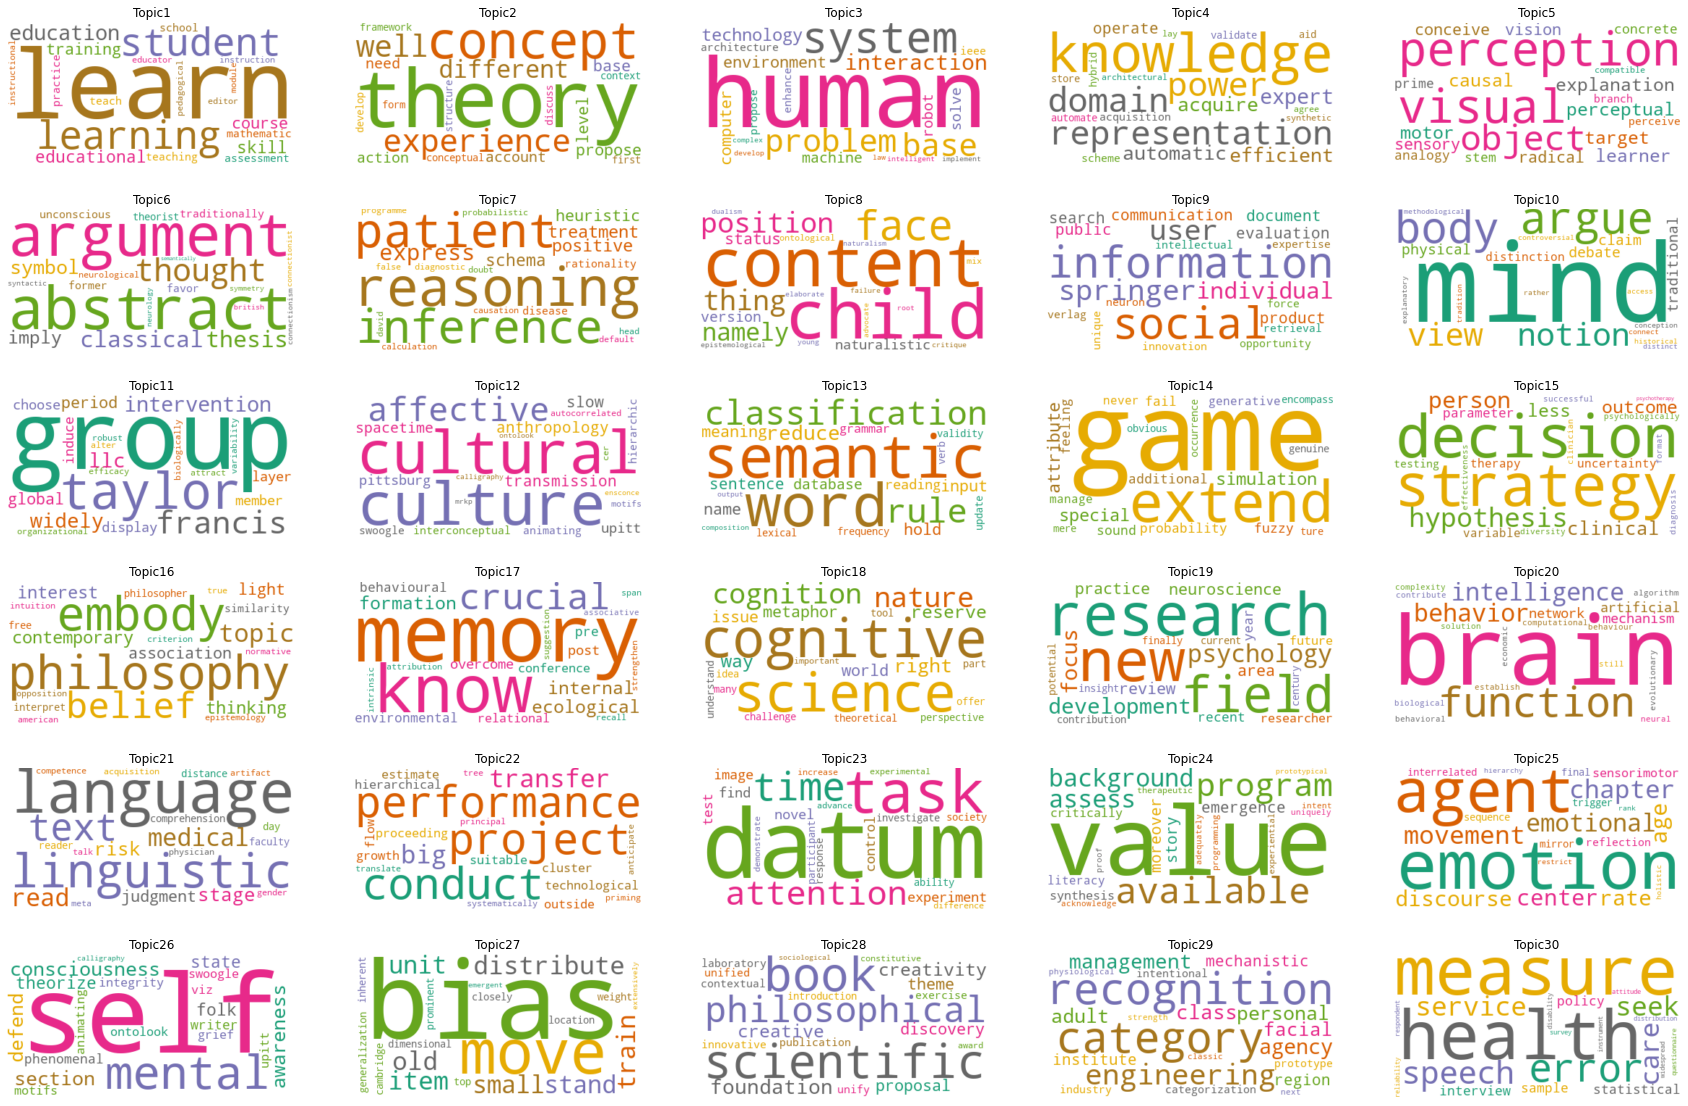

In [77]:
# Create subplots for each topic
for i in range(30):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(6, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()